# 第八次计算物理作业

学号： 2021300002018

姓名： 朱向阳

## 题目

进行非线性阻尼摆的熵分析，该摆在第3章中进行了研究。考虑$\theta(t)$的行为，并将$\theta$的可能范围分成若干个单元（尝试100个）。模拟摆，并计算摆角落入每个单元的次数的直方图，作为$\theta$的函数；与驱动力同步采样$\theta(t)$，就像我们在计算庞加莱截面时所做的那样。使用(7.24)计算熵作为驱动力的函数。你应该发现在周期性状态下熵很小，在摆混沌时熵很大。在周期2和周期4状态下熵是多少？

## 解答

+ 为同时保证效率和精确度，在写第三章作业的时候我写并测试了numpy和cython的速度，均不如人意，最后采用C++才得到快速且满意的结果.

+ 本次依然采用C++编写计算部分的源代码，因为需要最后统计theta的直方图，约100格，原本只从300周期-400周期共100周期数量过少，而经实际测试，所取精度**dt=0.0001**又不足以支撑**大周期数(>500)运算**，所以便采取从300周期到800周期**共500周期**, **dt=0.000001**, 进行画图分析.

+ 而这导致计算量又提升两个数量级，故使用C++多线程计算.

+ 计算环境i7-11800H, 计算线程10，相关代码在末尾;(python也能用thread或multiprocess等库，但是速度过慢，不做考虑).

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

num = 500
FD = np.arange(1.35, 1.5, 0.0001)

def normalize_theta(theta):
    theta -= (np.trunc(theta/(2*np.pi)))*(2*np.pi)
    condition = np.abs(theta) > np.pi
    indices = np.where(condition)
    theta[indices] -= 2 * np.pi * np.sign(theta[indices])
    return -theta

# result = ci_py(sindex, eindex, period_index, max_steps, length, q, OmegaD, g, dt, theta, omega, t, FD)

result = pd.read_csv('result_fast.csv').values.T[1:-1]
result = normalize_theta(result).astype(np.float64)

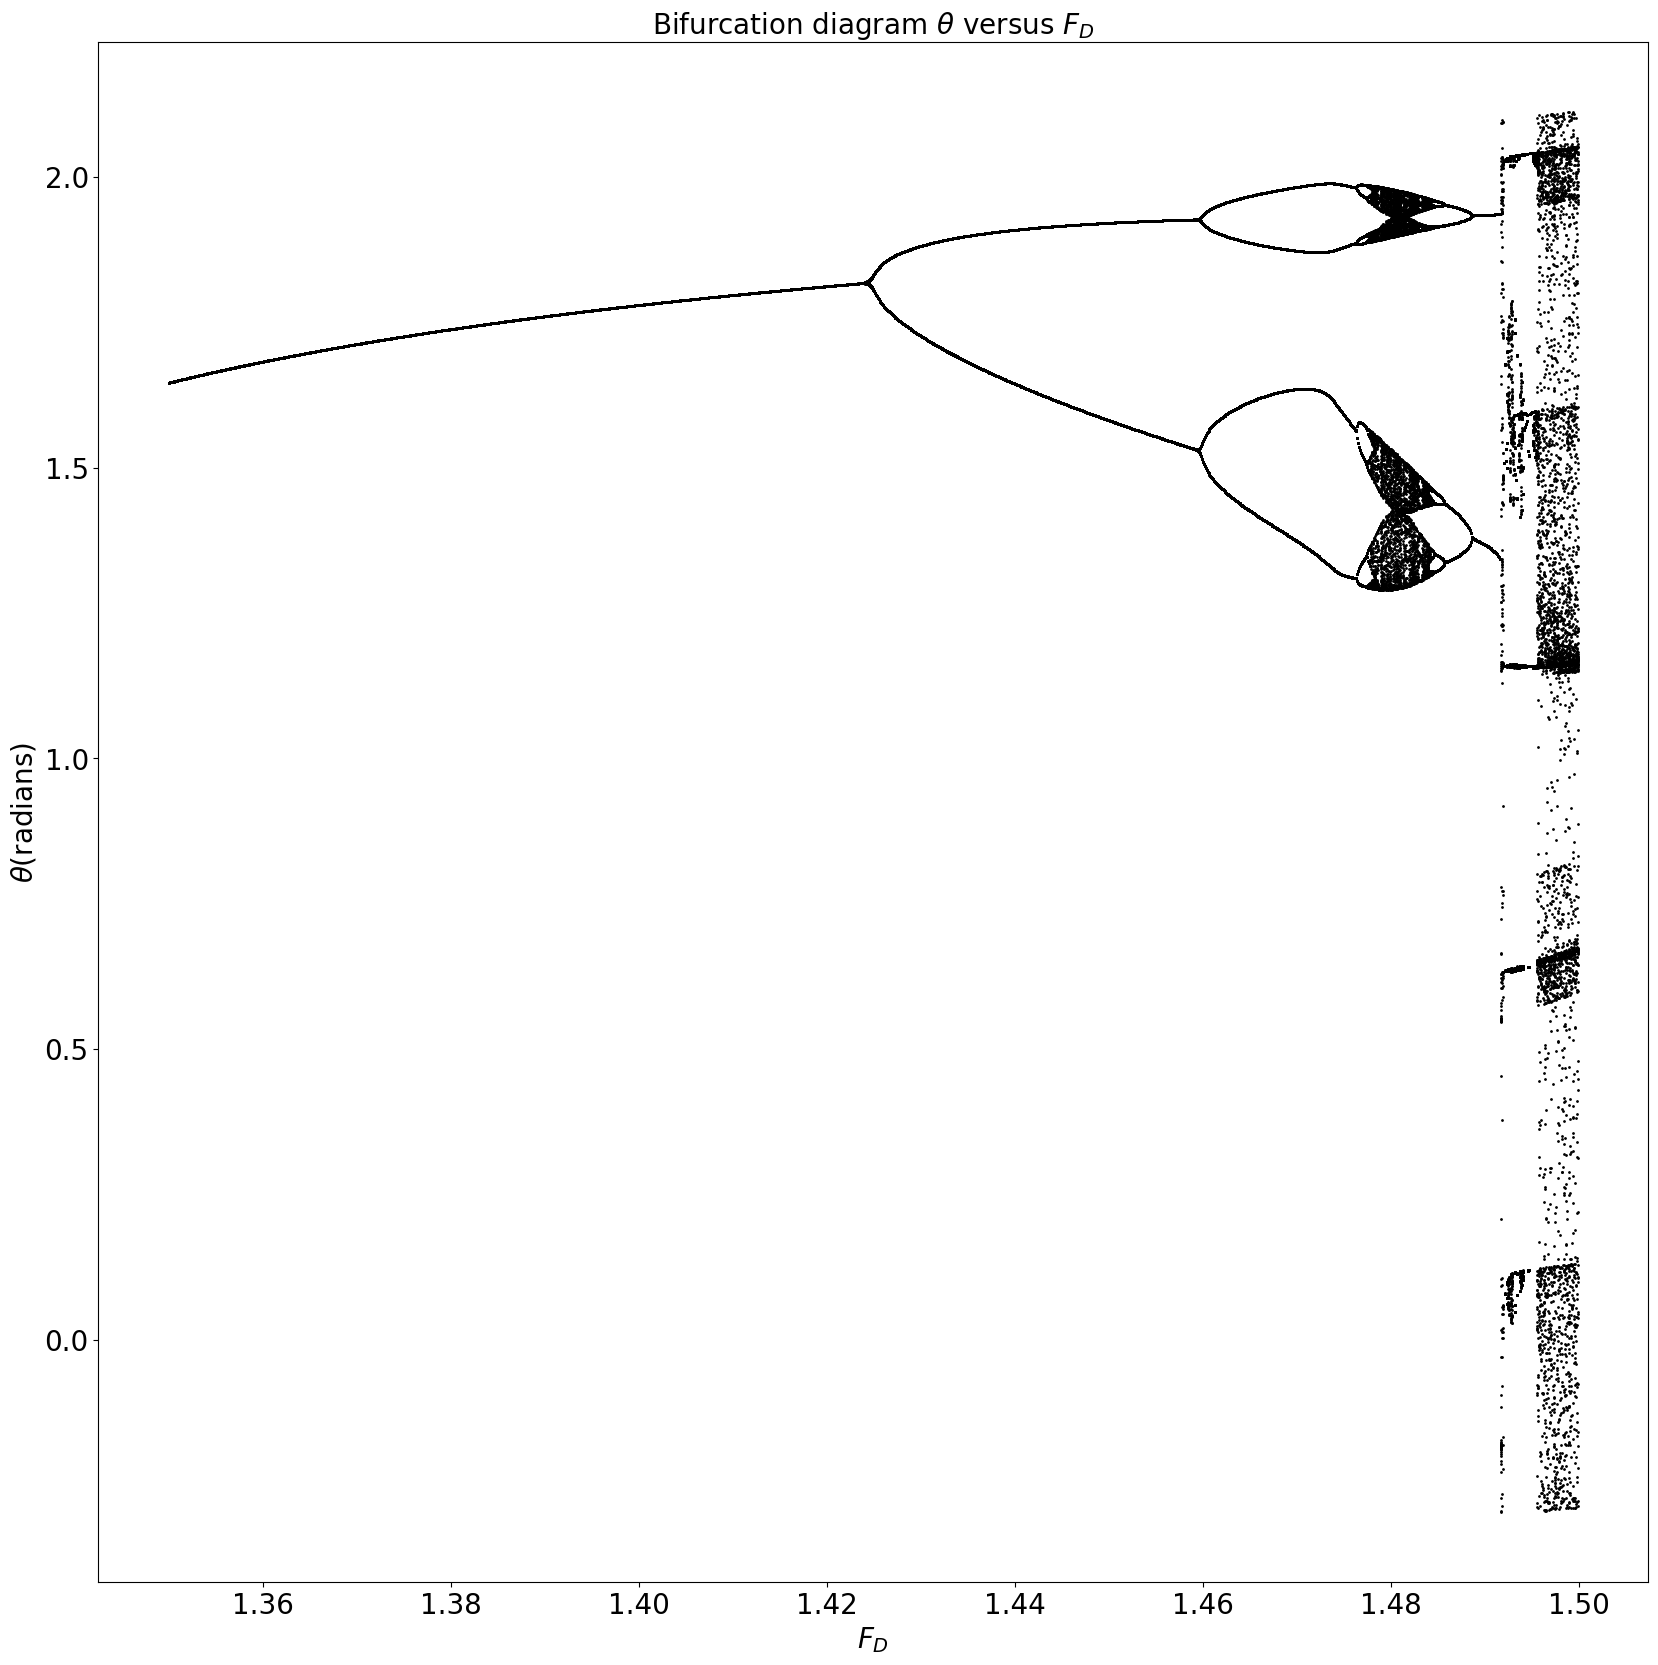

In [94]:
fig, ax = plt.subplots(figsize = (20, 20))
for fd,ys in zip(FD, result):
    fd = np.repeat(fd, ys.size)
    ax.scatter(x=fd, y=ys, color='black', s = 1)

ax.set_title(r'Bifurcation diagram $\theta$ versus $F_D$', size=20)
ax.set_xlabel(r'$F_D$', size=20)
ax.set_ylabel(r'$\theta$(radians)', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [76]:
rmin = np.min(result)
rmax = np.max(result)
# ds = (rmax - rmin) / num
dsh = np.pi / num
dsp = (rmax-rmin) / num
length = result.shape[1]

parray = np.zeros((1500, num), dtype=np.float64)
hista = np.zeros((1500, num), dtype=np.float64)
entropy = np.zeros(1500, dtype=np.float64)

为处理浮点误差以更好计算熵，不直接使用原始数据范围分为100份，而是从当前组数据的中位数开始向两侧拆分.

In [77]:
for i in range(1500):
    fd = FD[i]
    ys = result[i]
    mid = ys[int(num/2)]
    for j in range(num):
        y = ys[j]
        indexh = np.floor(np.abs(y / dsh)).astype(np.int64)
        indexp = np.floor(np.abs((y - mid) / dsp)).astype(np.int64)
        hista[i][j] = indexh
        parray[i][indexp] += 1/num

    entropy[i] = -np.sum(parray[i] * np.log(parray[i], out=np.zeros_like(parray[i]), where=(parray[i]!=0)))


直方图

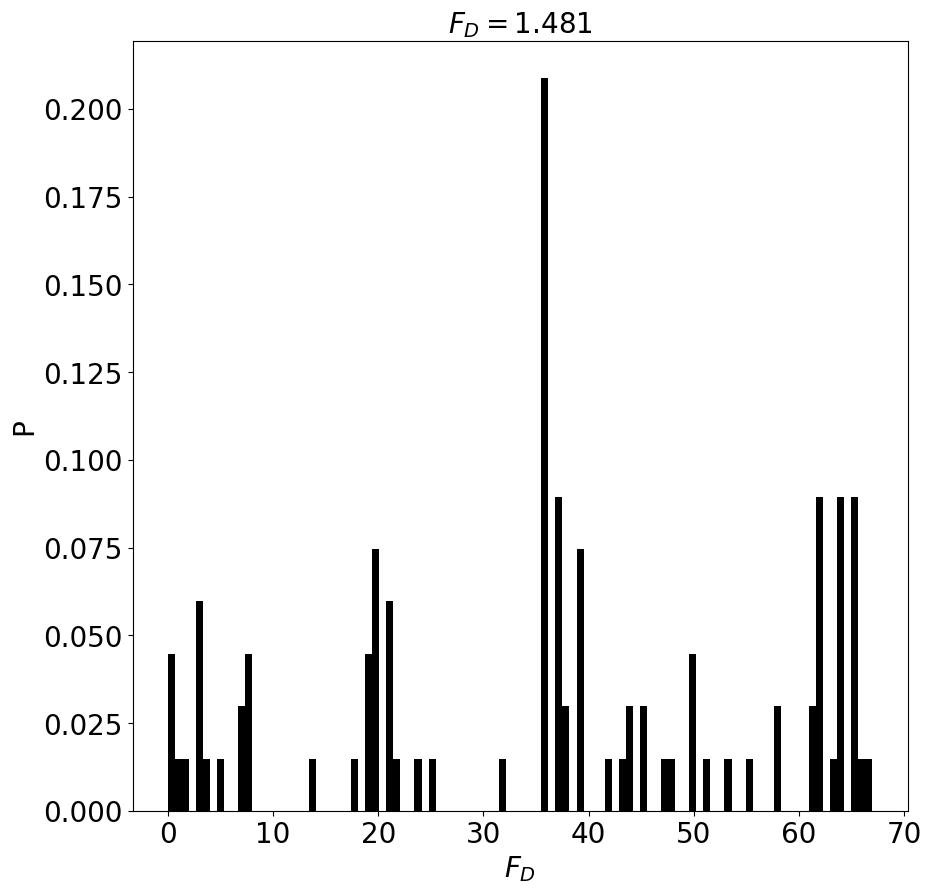

In [87]:
fd = 1.481
fig, ax = plt.subplots(figsize = (10, 10))
ax.hist(hista[int(fd*1000)], num, density=True, color='black')

ax.set_title(r'$F_D={}$'.format(fd), size=20)
ax.set_xlabel(r'$F_D$', size=20)
ax.set_ylabel(r'P', size=20)

plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

熵图

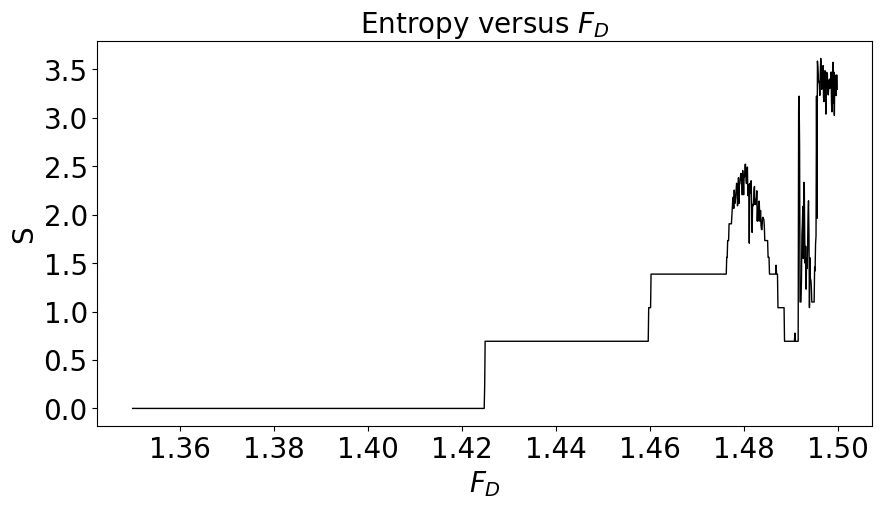

In [88]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(FD, entropy, color='black', lw = 1)

ax.set_title(r'Entropy versus $F_D$', size=20)
ax.set_xlabel(r'$F_D$', size=20)
ax.set_ylabel(r'S', size=20)

plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

## C++代码
使用了一些较为暴力的手段来优化提高计算效率， 编译选项：

``` bash
gcc -O3 calc_fast.cpp -funroll-loops -o calc_fast -lm -lstdc++ -pthread -std=c++11
```

``` C++
#include <cstdio>
#include <cmath>
#include <cstring>
#include <thread>
#define _USE_MATH_DEFINES
#define MAX_ROW 500
#define num_threads 10
using namespace std;

void write_to_csv(register unsigned int rows);

double dt = 0.000001;
unsigned int FDn = 1500;
double result[1500+5][MAX_ROW+5];

void compute(register unsigned int start, register unsigned int end, register unsigned int thread_id, double glength, double q, double FDs, double FDe, double FDeps, double OmegaD, double theta0, double omega0, register unsigned int sindex, register unsigned int eindex, register unsigned int period_index)
{
    register unsigned int k = 0;
    double fds = 0.0, fde = 0.0, t = 0.0, a = 0.0, b = 0.0, c = 0.0, d = 0.0;
    
    fds = FDs + (double)start * FDeps;
    fde = FDs + (double)end * FDeps;
    register unsigned int j = start, i = 0;
    for (; fds < fde; fds+=FDeps)
    {
        a = theta0;
        c = omega0;
        t = 0.0;
        i = 0;
        k = 0;
        
        for(i = 0; i <= sindex; i++)
        {
            d = c - glength * sin(a) * dt - q*c*dt + fds*sin(OmegaD*t)*dt;
            b = a + c*dt;
            a = b;
            c = d;

            t += dt;
        }

        for(; i <= eindex; i++)
        {
            d = c - glength * sin(a) * dt - q*c*dt + fds*sin(OmegaD*t)*dt;
            b = a + c*dt;
            t += dt;

            if (i % period_index == 0)
            result[j][k++] = c;

            a = b;
            c = d;
        }
        if(thread_id == 0)
        printf("%d\n", j);
        j++;

    }
}

int main()
{
    double g = 9.8, length = 9.8, theta0 = 0.2, omega0 = 0, q = 0.5, FDs = 1.35, FDe = 1.5, FDeps = 0.0001, OmegaD = 2.0/3.0, period, times, timee;

    register unsigned int period_index;
    period = (2 * M_PI) / OmegaD;
    period_index = int(period / dt);
    printf("%d\n", period_index);
    getchar();

    int hit = 300;
    register unsigned int nsth = hit, neth = hit + MAX_ROW, sindex, eindex;

    memset(result, 0, sizeof(result));

    times = (nsth - 1) * period;
    timee = (neth - 1) * period;
    sindex = int(times / dt);
    eindex = int(timee / dt) + 1;

    thread threads[num_threads];
    register unsigned int steps_per_thread = FDn / num_threads;
    for (register unsigned int i = 0; i < num_threads; i++)
    {
        register unsigned int start = i * steps_per_thread;
        register unsigned int end = (i + 1) * steps_per_thread;
        if (i == num_threads - 1)
            end = FDn;
        threads[i] = thread(compute, start, end, i, g/length, q, FDs, FDe, FDeps, OmegaD, theta0, omega0, sindex, eindex, period_index);
    }

    for (register unsigned int i = 0; i < num_threads; i++)
    {
        threads[i].join();
    }

    write_to_csv(FDn);
    printf("Output completed!\n");
    getchar();
    return 0;
}

void write_to_csv(register unsigned int rows)
{
    FILE *file = fopen("result_fast.csv", "w+");
    if (file == NULL)
    {
        printf("Failed to open file.\n");
        return;
    }

    fprintf(file, ",");
    for (register unsigned int row = 0; row < rows; row++)
    {
        fprintf(file, "R%d,", row + 1);
    }
    fprintf(file, "\n");

    for (register unsigned int col = 0; col < MAX_ROW; col++)
    {
        fprintf(file, "C%d,", col + 1);
        for (register unsigned int row = 0; row < rows; row++)
        {
            fprintf(file, "%lf,", result[row][col]);
        }
        fprintf(file, "\n");
    }

    fclose(file);
}
```
